10. **[Decision Tree Regressor](#tree)**
    - 10.1 -**[Decision Tree hyperparameter tuning](#tree_tuning)**
11. **[Random Forest Regressor](#rf)**
    - 10.1 -**[Random Forest hyperparameter tuning](#rf_tuning)**


In [339]:
import numpy as np
import pandas as pd

from scipy.stats import zscore,iqr
import scipy.stats as stats

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.ensemble import VotingRegressor,StackingRegressor

from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold,RepeatedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import RFECV,RFE
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer,LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from statsmodels.api import add_constant,OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from collections import Counter
from wordcloud import WordCloud

from warnings import filterwarnings
filterwarnings(action='ignore')

%matplotlib inline

- Importing user defined functions from module **auto_mpg_functions.py** 

In [340]:
from auto_mpg_functions import report
from auto_mpg_functions import interval_estimate

In [341]:
%store -r

## 1) Decision Tree

In [342]:
df_tree = df_tree.drop(columns=['car_name'])
df_tree['cylinders'] = df_tree['cylinders'].astype(object)

encode = LabelEncoder()

for i in ['model_year', 'origin']:
    df_tree[i] = encode.fit_transform(df_tree[i])

In [343]:
X = df_tree.iloc[:,1:]
y = df_tree.iloc[:,[0]]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=58)

In [344]:
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train,y_train)

report(tree,X_train,X_test,y_train,y_test)

** DecisionTreeRegressor Evaluation & Report **
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 0.0000 mpg
Test RMSE = 4.5659 mpg
Variance = 4.5659 mpg
--------------------------------------------------
Cross validation RMSE : 3.3328 mpg
--------------------------------------------------
Cross validation R2_score : 78.10 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 0.0000 mpg
Test MAE = 2.9738 mpg
Variance = 2.9738 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------------------------------------
Train MAPE = 0.00 % 
Test MAPE = 12.05 % 
Variance = 12.05 %


- from above report we can say, the Decision tree is overfitting
- Let's use ccp_alpha to tune hyper_parameters to reduce variance

In [345]:
scoring = 'neg_root_mean_squared_error'
cv = KFold(n_splits=5,shuffle=True,random_state=55)
score = cross_val_score(tree,X_train,y_train,cv=cv,scoring=scoring)*-1
score.mean(),score.std()

(3.4444574990845567, 0.35474728068585537)

In [349]:
prune_tree = DecisionTreeRegressor()
scoring3 = 'neg_root_mean_squared_error'

cv_prune = KFold(n_splits=5,shuffle=True,random_state=55)
prun_tree_grid = GridSearchCV(prune_tree,param_grid={'ccp_alpha' : path['ccp_alphas']},cv=cv_prune,scoring=scoring3)
prun_tree_grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=55, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': array([0.00000000e+00, 7.01770603e-16, 1.54320988e-05, 1.54320988e-05,
       1.54320988e-05, 1.54320988e-05, 1.54320988e-05, 1.54320988e-05,
       1.54320988e-05, 1.54320988e-05, 1.54320988e-05, 1.54320988e-05,
       2.05761317e-05, 2.05761317e-05, 6.17283951e-...
       1.04339015e-01, 1.14244529e-01, 1.19729345e-01, 1.32753987e-01,
       1.56481481e-01, 1.66190205e-01, 1.68612970e-01, 2.14670174e-01,
       2.20651350e-01, 2.25774820e-01, 2.51875594e-01, 2.53431556e-01,
       2.69265561e-01, 2.84079218e-01, 3.47736626e-01, 5.95300599e-01,
       6.83686451e-01, 7.43715440e-01, 1.61551135e+00, 2.40093749e+00,
       2.60546050e+00, 3.90544813e+00, 3.20749629e+01])},
             scoring='neg_root_mean_squared_error')

In [350]:
prun_tree_grid.best_params_['ccp_alpha']

0.16861296987930863

In [351]:
ccp_pruned_tree = DecisionTreeRegressor(ccp_alpha=prun_tree_grid.best_params_['ccp_alpha'])
ccp_pruned_tree.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.16861296987930863)

In [352]:
report(ccp_pruned_tree,X_train,X_test,y_train,y_test)

** DecisionTreeRegressor Evaluation & Report **
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.1420 mpg
Test RMSE = 4.3454 mpg
Variance = 2.2034 mpg
--------------------------------------------------
Cross validation RMSE : 3.0020 mpg
--------------------------------------------------
Cross validation R2_score : 82.01 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.7184 mpg
Test MAE = 2.8806 mpg
Variance = 1.1622 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------------------------------------
Train MAPE = 7.95 % 
Test MAPE = 11.76 % 
Variance = 3.80 %


### Tuning hyperparameters of Decision tree using GridsearchCV

In [353]:
cv = KFold(n_splits=5,shuffle=True,random_state=55)
scoring1 = 'neg_root_mean_squared_error'
scoring2 = 'r2'
param_grid = {'criterion' : ['squared_error','friedman_mse'],
             'splitter' : ['best', 'random'],
             'max_depth' : range(4,8),
             'min_samples_split' : range(4,12),
             'min_samples_leaf': [3,4,5],
             'max_features': [3,4,5],
             'min_impurity_decrease': [0.05,0.075,0.1]}

tree_grid = GridSearchCV(tree,param_grid=param_grid,scoring=scoring1,cv=cv)
tree_grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=55, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': range(4, 8), 'max_features': [3, 4, 5],
                         'min_impurity_decrease': [0.05, 0.075, 0.1],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': range(4, 12),
                         'splitter': ['best', 'random']},
             scoring='neg_root_mean_squared_error')

In [354]:
tree_grid.best_score_

-2.9010551512676304

In [355]:
tuned_tree = DecisionTreeRegressor()
tuned_tree.set_params(**tree_grid.best_params_)
tuned_tree.fit(X_train,y_train)

report(tuned_tree,X_train,X_test,y_train,y_test)

** DecisionTreeRegressor Evaluation & Report **
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.1650 mpg
Test RMSE = 3.5615 mpg
Variance = 1.3964 mpg
--------------------------------------------------
Cross validation RMSE : 3.3150 mpg
--------------------------------------------------
Cross validation R2_score : 77.71 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.6592 mpg
Test MAE = 2.6271 mpg
Variance = 0.9679 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------------------------------------
Train MAPE = 7.67 % 
Test MAPE = 10.80 % 
Variance = 3.13 %


- Displacement is having highest feature importance in hyperparamter tuned Decision tree 

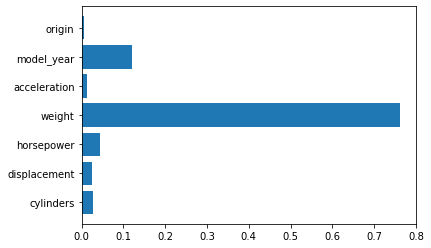

In [356]:
plt.barh(tuned_tree.feature_names_in_,tuned_tree.feature_importances_)
plt.show()

## 2) Random Forest

In [116]:
rf = RandomForestRegressor(random_state=42,oob_score=True)

- Data pre-processing

In [120]:
X = df_tree.iloc[:,1:]
y = df_tree[['mpg']]

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42)

In [122]:
rf.fit(X_train,y_train)

RandomForestRegressor(oob_score=True, random_state=42)

In [123]:
report(rf,X_train,X_test,y_train,y_test)

** RandomForestRegressor Evaluation & Report **
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 1.0404 mpg
Test RMSE = 2.3131 mpg
Variance = 1.2728 mpg
--------------------------------------------------
Cross validation RMSE : 2.8883 mpg
--------------------------------------------------
Cross validation R2_score : 83.26 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 0.7579 mpg
Test MAE = 1.7649 mpg
Variance = 1.0070 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------------------------------------
Train MAPE = 3.39 % 
Test MAPE = 9.28 % 
Variance = 5.89 %


- Out of bag score

In [127]:
rf.oob_score_

0.8391772667850605

- from above report we can clearly see that Random forest is overfitting
- let's do hyperparameter tuning

### Random forest hyperparameter tuning

In [134]:
cv_rf = KFold(n_splits=5,shuffle=True,random_state=55)
scoring1 = 'neg_root_mean_squared_error'
param_grid = {'criterion' : ["squared_error", "absolute_error"],
              'n_estimators': range(0,1000,10),
              'bootstrap' : [True,False],
             'max_depth' : range(4,8),
             'min_samples_split' : range(4,12),
             'min_samples_leaf': [3,4,5],
             'max_features': [0.3,0.4,0.5,0.6,0.7,0.8],
             'min_impurity_decrease': [0.05,0.075,0.1]} 

In [142]:
rf_random = RandomizedSearchCV(rf,param_distributions=param_grid,scoring=scoring1,cv=cv_rf,
                               random_state=56)

In [143]:
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=55, shuffle=True),
                   estimator=RandomForestRegressor(max_depth=7,
                                                   max_features=0.3,
                                                   min_impurity_decrease=0.075,
                                                   min_samples_leaf=5,
                                                   min_samples_split=11,
                                                   n_estimators=360,
                                                   oob_score=True,
                                                   random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': range(4, 8),
                                        'max_features': [0.3, 0.4, 0.5, 0.6,
                                                         0.7, 0.8],
                                        'min_impurity_decrease': [0.05, 0.075,
                                                                  0.1],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': range(4, 12),
                                        'n_estimators': range(0, 1000, 10)},
                   random_state=56, scoring='neg_root_mean_squared_error')

In [144]:
tuned_rf = rf.set_params(**rf_random.best_params_)
tuned_rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, max_features=0.3,
                      min_impurity_decrease=0.075, min_samples_leaf=5,
                      min_samples_split=11, n_estimators=360, oob_score=True,
                      random_state=42)

In [145]:
report(tuned_rf,X_train, X_test, y_train, y_test)

** RandomForestRegressor Evaluation & Report **
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.4195 mpg
Test RMSE = 2.7185 mpg
Variance = 0.2989 mpg
--------------------------------------------------
Cross validation RMSE : 2.9415 mpg
--------------------------------------------------
Cross validation R2_score : 82.26 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.7596 mpg
Test MAE = 2.0099 mpg
Variance = 0.2503 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------------------------------------
Train MAPE = 7.88 % 
Test MAPE = 10.71 % 
Variance = 2.83 %


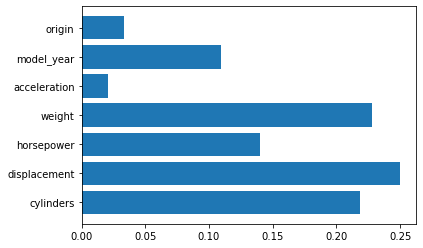

In [146]:
plt.barh(tuned_rf.feature_names_in_,tuned_rf.feature_importances_)
plt.show()

## 3) Bagging Regressor

In [176]:
df = df_upto_preprocess.copy()

In [177]:
cat_variable = ['cylinders','model_year','origin',]
numeric_variable = ['displacement','horsepower','acceleration','weight']

In [186]:
df_categorical = pd.get_dummies(df[cat_variable].astype(str),drop_first=True)
df_numeric = df[numeric_variable]
Xr = pd.concat([df_numeric,df_categorical],axis=1)
y = df[['mpg']]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr,y,test_size=0.2, random_state=42)

In [329]:
linear_reg_bag = LinearRegression()
tree_bag = DecisionTreeRegressor()
svm_bag = SVR()
Knn_bag = KNeighborsRegressor()

scoring1 = 'neg_root_mean_squared_error'

param_bagging = {'base_estimator': [linear_reg_bag,tree_bag,svm_bag,Knn_bag],
                 'n_estimators': range(2,10),
                 'max_samples': [0.6,0.7,0.8],
                 'max_features': [0.5,0.6,0.7],
                 'bootstrap': [True],
                 'bootstrap_features': [True,False]}

In [330]:
bagging = BaggingRegressor(random_state=445)

In [331]:
bagging_grid = GridSearchCV(bagging,param_grid=param_bagging,scoring=scoring1)

In [332]:
bagging_grid.fit(X_train,y_train)

GridSearchCV(estimator=BaggingRegressor(random_state=445),
             param_grid={'base_estimator': [LinearRegression(),
                                            DecisionTreeRegressor(), SVR(),
                                            KNeighborsRegressor()],
                         'bootstrap': [True],
                         'bootstrap_features': [True, False],
                         'max_features': [0.5, 0.6, 0.7],
                         'max_samples': [0.6, 0.7, 0.8],
                         'n_estimators': range(2, 10)},
             scoring='neg_root_mean_squared_error')

In [333]:
tuned_bag = BaggingRegressor(**bagging_grid.best_params_)
tuned_bag.fit(X_train,y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_features=0.6,
                 max_samples=0.8, n_estimators=8)

In [334]:
report(tuned_bag,X_train, X_test, y_train, y_test)

** BaggingRegressor Evaluation & Report **
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 1.6049 mpg
Test RMSE = 3.4610 mpg
Variance = 1.8562 mpg
--------------------------------------------------
Cross validation RMSE : 2.9648 mpg
--------------------------------------------------
Cross validation R2_score : 84.91 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.1603 mpg
Test MAE = 2.2764 mpg
Variance = 1.1161 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------------------------------------
Train MAPE = 5.56 % 
Test MAPE = 9.56 % 
Variance = 4.00 %


- lets use Decision tree with best hyperparameters

In [335]:
best_param_bagging = {'base_estimator': tuned_tree,
                      'bootstrap': False,
                      'bootstrap_features': False,
                      'max_features': 0.6,
                      'max_samples': 0.7,
                      'n_estimators': 8}

In [336]:
best_tree_bagging = BaggingRegressor(**best_param_bagging,random_state=445)
best_tree_bagging.fit(X_train,y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                      max_depth=6,
                                                      max_features=3,
                                                      min_impurity_decrease=0.05,
                                                      min_samples_leaf=3,
                                                      min_samples_split=9),
                 bootstrap=False, max_features=0.6, max_samples=0.7,
                 n_estimators=8, random_state=445)

In [338]:
report(best_tree_bagging,X_train, X_test, y_train, y_test)

** BaggingRegressor Evaluation & Report **
--------------------------------------------------
Root mean squared Error
--------------------------------------------------
Train RMSE = 2.1964 mpg
Test RMSE = 3.4648 mpg
Variance = 1.2684 mpg
--------------------------------------------------
Cross validation RMSE : 2.9904 mpg
--------------------------------------------------
Cross validation R2_score : 82.35 % 
--------------------------------------------------
Mean Absolute Error
--------------------------------------------------
Train MAE = 1.6180 mpg
Test MAE = 2.2625 mpg
Variance = 0.6445 mpg
--------------------------------------------------
Mean Absolute Percentage Error
--------------------------------------------------
Train MAPE = 7.38 % 
Test MAPE = 9.25 % 
Variance = 1.87 %
